In [66]:
from __future__ import print_function
__author__= 'fbb'
import pylab as pl
import numpy as np
import os
from scipy.optimize import curve_fit, minimize
    
import json
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am creating a variable PLOT. if it is set to True the code makes a whole bunch of additional plots. 

##Plotting is a crucial doagnostinic! plot your distributions, and as soon as you have a bug plot everything that you can plot that leads to that point in the code**

now the PLOT variable is set to False, and nothing but what is required plots. also notice that it is all caps. Normally variables are lower case (see PEP8) but this is sort of a global variable functionally in my code, so i leave it all caps to distibguish it from functional variables in the code.

In [67]:
PLOT = False

mymu = 100
mydistribs = {}
fig = None
distributions = ['pois', 'gaus', 'chisq', 'gamma', 'lnorm', 'binomial']


this function generates each one of my disgrubtions. as for the the workflow: this was originally not a separated function, but once i had it in the for loop the code was very hard to read, so i moved this bit to a separate function. 

In [69]:
def gendistribs(mu, n, md, fig=None):
    md['means'] = {}
    #print (mu)
    md['pois'] = np.random.poisson(lam = mu, size = n)
    md['gaus'] = np.random.randn(n) + mu
    md['chisq'] = np.random.chisquare(mu, size = n)
    md['lnorm'] = np.random.lognormal(mean = np.log(mu) - 0.5, size = n)
    md['binomial'] = np.random.binomial(mu * 10, 0.1, size = n)
    md['gamma'] = np.random.gamma(1, 100, n)

    
    for dist in distributions:
#        print (md[dist].mean())
        md['means'][dist] = md[dist].mean()
        
    if fig:
        ax = fig.add_subplot(231)
        ax.hist(md['pois'], label = 'pois %d'%n)
        ax.legend()
        ax = fig.add_subplot(232)
        ax.hist(md['gaus'], label = 'gaus %d'%n)
        ax.legend()
        ax = fig.add_subplot(233)
        ax.hist(md['chisq'], label = 'chisq %d'%n)
        ax.legend()
        ax = fig.add_subplot(234)
        ax.hist(md['lnorm'], label = 'lnorm %d'%n)
        ax.legend()
        ax = fig.add_subplot(235)
        ax.hist(md['binomial'], label = 'binomial %d'%n)
        ax.legend()
        ax = fig.add_subplot(236)
        #ax.hist(md['pareto'], label = 'pareto %d'%n)
        ax.hist(md['gamma'], label = 'gamma %d'%n)
        ax.legend()
          


this is a wraper function that passes arguments to gendistrib and plots. again, this has been moved to its own function for readability, it does not need to be separated from the foor loop computationally, but it helps the human interaction with the code

In [90]:
def alldistribs(Nsize, ax):
    mydistribs={}
    for i,n in enumerate([Nsize]):
        if PLOT: fig = pl.figure(figsize = (10,10))
        mydistribs[i] = {'n': n}
        gendistribs(mymu, n, mydistribs[i], fig=None)

    means = []
    
    for k in mydistribs.iterkeys():
        for j in mydistribs[k]['means'].iterkeys():
            means.append(mydistribs[k]['means'][j])
            ax[j].plot(mydistribs[k]['n'], mydistribs[k]['means'][j],'o')
            ax[j].plot([10,2000], [mymu,mymu], 'k--', lw=3, alpha=0.5)
            ax[j].legend()
            ax[j].set_title(j, fontsize=20)
#            print (mydistribs[k]['n'], len(mydistribs[k][j]))
#    allmeans=[means[j] for j in mydistribs[:]['means']]
    h, bin_edges, patches = pl.hist(means, bins = 30, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    return means, h, bin_centers


Now notice how the indentation goes back to the no-indent in the next cell: i am in the body of the code. 

##why am i chosing to step the size as 
##for nsize in np.linspace(np.sqrt(10), np.sqrt(2000), 100)**2: ?

** i am using interval that are linear in the square root space of N. that is because the effect i expect is proportional to the sqrt(N): the standard deviation of the sample decreases as sqrt(N). so if the range of my y variable shrinks as sqrt(N) my steps will look best if they are spaced evenly as a function of sqrt(N): the curvature of the plot will look circular (in a square plot) and the effect will be optimally displayes. we will talk more about how to make your visualizations compelling in the second part of the course. **

dont fixate on this if it is not clear: we will discuss things like this more. any choice for the sizes was fine, as long as it gives an idea of the effects we are seeking 



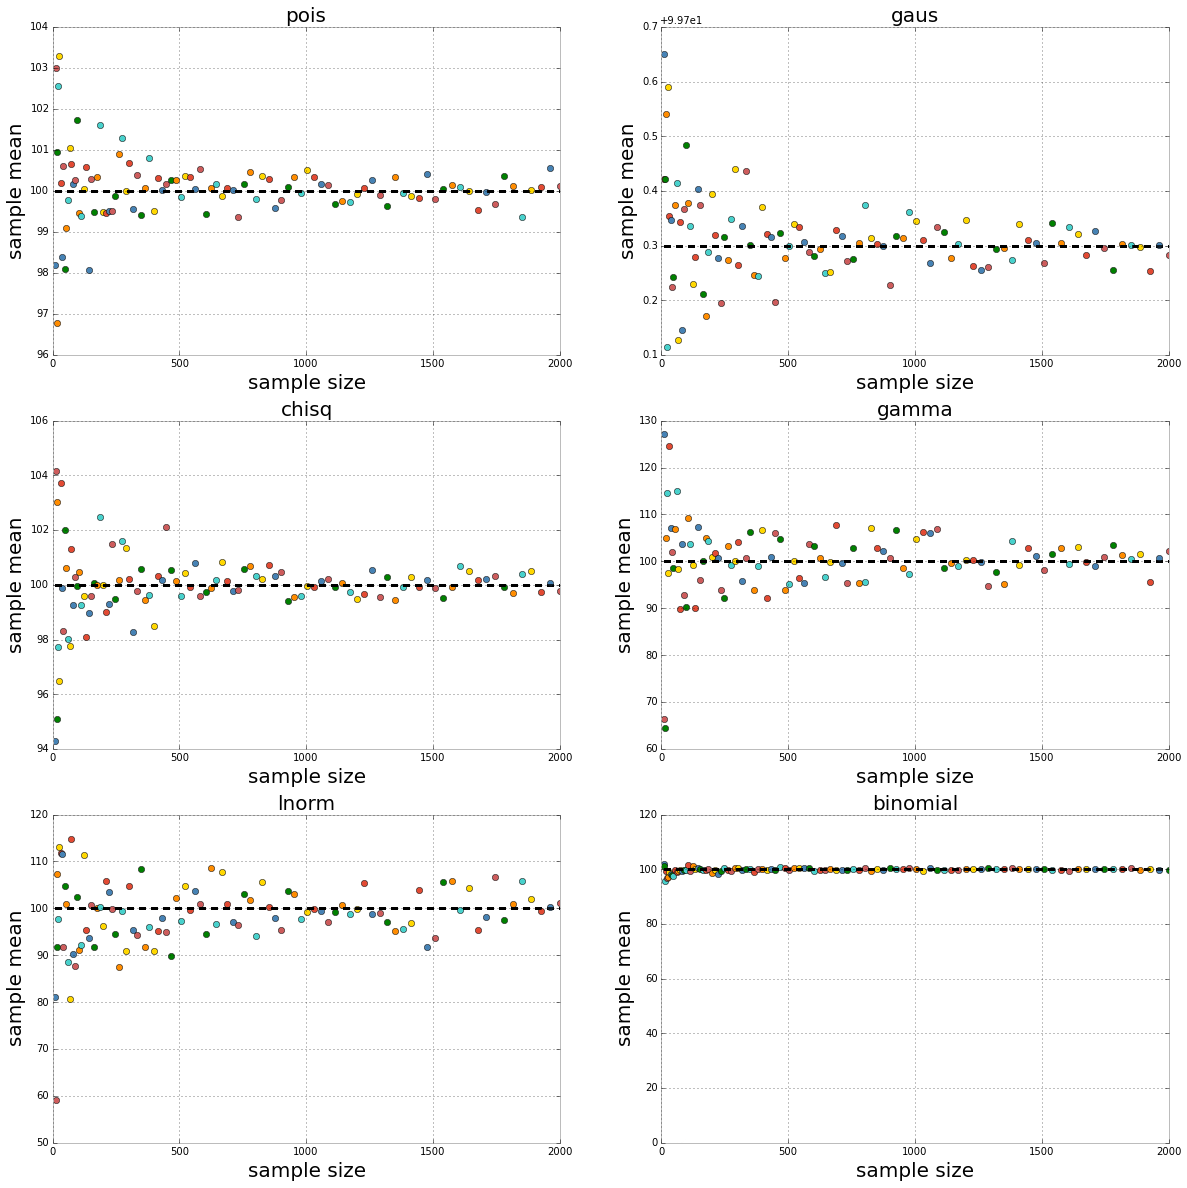

In [140]:
#i organized my data in a dictionary. that is NOT REQUIRED! it is just a choice
#if you used a dictionary and you use random to generate the sizes 
#you **must have made sure** that the numbers you generate are unique, since only unique
#dictionary keys are allowed in python


ax={}
fig=pl.figure(figsize=(20,20))
for i, d in enumerate(distributions):
#    print (i+1, d, distributions)
    ax[d]=fig.add_subplot(3,2,i+1)
    #LABEL YOUR AXIS! 
    ax[d].set_xlabel("sample size", fontsize=20)
    ax[d].set_ylabel("sample mean", fontsize=20)

all_means = []
for nsize in np.linspace(np.sqrt(10), np.sqrt(2000), num = 100)**2:
#    fig2 = pl.figure(figsize = (5,5))
    nsize=int(nsize)
    these_means, hist, bin_centers = alldistribs(nsize, ax)
    coeffs = fitfunction(hist, bin_centers)
    all_means.append(np.array(these_means))



##Caption: 
the the mean of the sample converges to the mean of the population as the size increases and that the variance of the mean of the samples is smaller as the sample size increases. This is a consequence of the Central Limit Theorem. The variance is larger for some distribution (notice the different range spanned by the y axis in each subplot) than it is for others. 

#Part 2

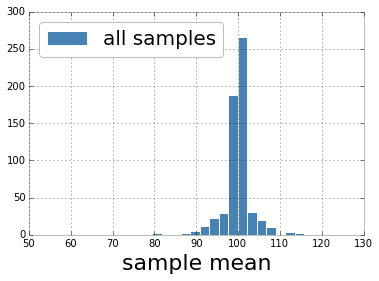

In [249]:
all_means = np.array(all_means).flatten()
pl.hist(all_means, bins = 30, label= "all samples")
pl.xlabel("sample mean", fontsize = 22)
pl.legend(loc = 2, fontsize = 20)

##Caption:
the sample means are distributed in a bell shaped distribution. 
We expect this distribution to be a gaussian bcause of the Central Limit Theorem

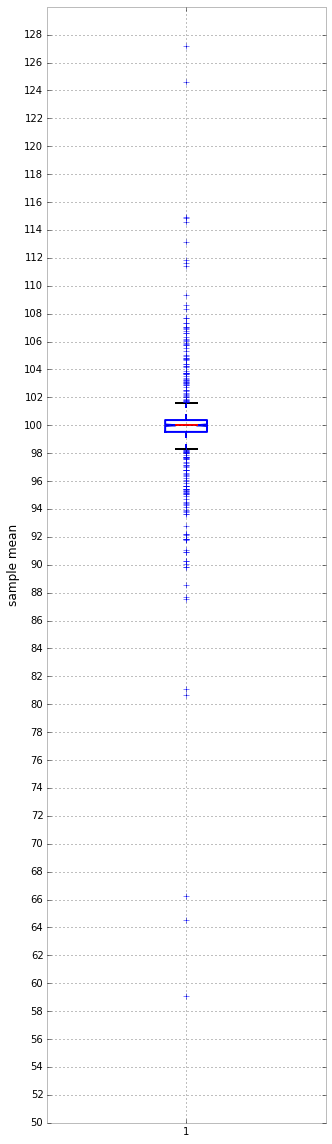

In [163]:
fig = pl.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
ax.boxplot(all_means, ylabel("sample mean"))
ax.grid(True)
ax.set_yticks(range(50, 130, 2))

##Caption:
a box and whiskers shows the median of the distribution at 100, which is equal to the sample mean, as expected. The Interquartile range id very narrow around 100 (< +/- 2) but there is a large number of "outliers" (datapoints outside of the 3 quartiles). This is a reflection of the fact that the dispersion (which can be measured as the standard deviation) in the mean measurements decreases rapidly with the sample size, since it is proportional to ~sqrt(N). 

#Part 3 (extra credit)
I am fitting a gaussian to the  distribution of all means. Because i saw the histogram and the box plot i do not expect the fit to be great: the tail have a lot of power.

I am using 2 methods: numpy curve_fit and numpyo minimize, for which i have to create a residual function to be minimized. I take the result of curve_fit, but i inspect it with the resid result. Note that both methods are "greedy": they may get stuck in local minima. 

I initialize the fit with my expectation: mu=100, sigma=1, and a nuisance parameter A is the normalization parameter, which i do not care for.

In [230]:
def resids (p, x, y):
    return(sum((np.vectorize(gauss)(x, p[0], p[1], p[2])-y)**2))

def gauss2(x, p):
    A, mu, sig = p
    return A / sigma / np.sqrt(2.0*pi) * numpy.exp( - (x - mu) ** 2 / (2. * sigma ** 2))

def gauss(x, *p):
    # i am printing the values of the parameters for which gauss gets evaluated, 
    #to make sure that the minimization has explored the parameter space a bit.
    #Normally i would remove this ugly output, but i want to leave it for you to see it.
    print (p)
    A, mu, sigma = p
    return A / sigma / np.sqrt(2.0*pi) * numpy.exp( - (x - mu) ** 2 / (2. * sigma ** 2))

def fitfunction(x, y):
    p0 = [1., 100., 1.]
    coeff, var_matrix = curve_fit(gauss, x, y, p0 = p0)
    result = minimize(resids, p0, args=(x, y))
    print (result)
    return coeff

I have created my own gaussian pdf. sometimes coding a bit of math is easier then understanding the package functions. 
most likely the package function is more efficient then what i would write on the spot, but if the computational requirements are small it is easy ok if the function is not maximally efficient

(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0, 100.00000149011612, 1.0)
(1.0, 100.0, 1.0000000149011612)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0, 1.0)
(1.0000000149011612, 100.0,

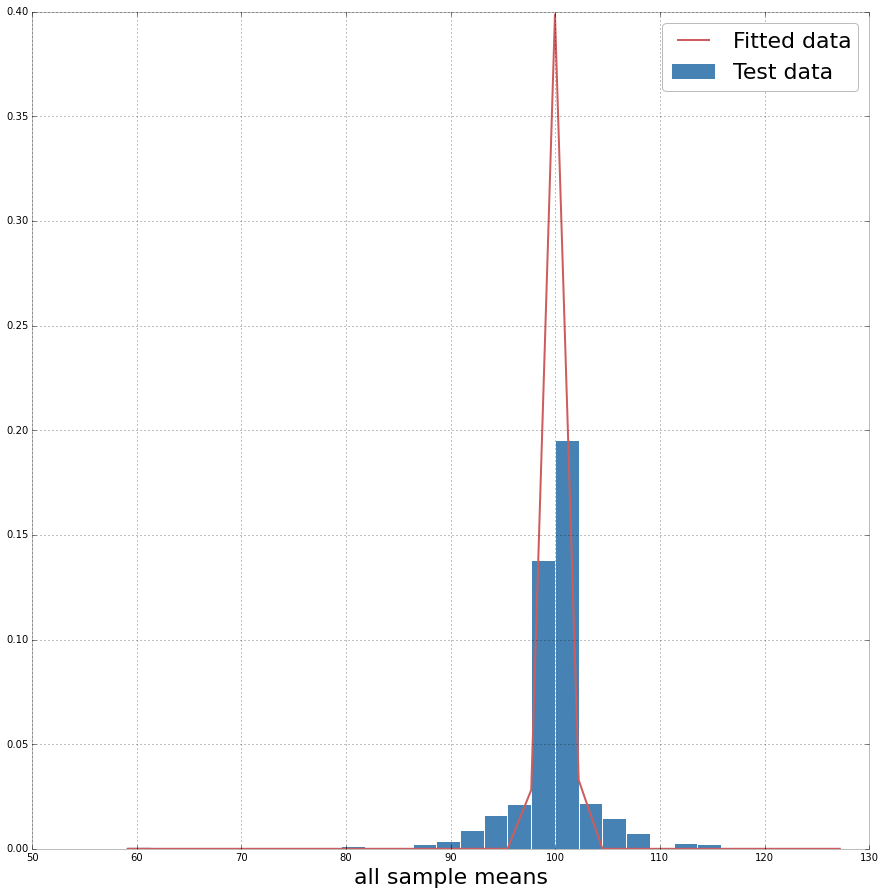

In [235]:
fig = pl.figure(figsize=(15,15))
hist, bin_centers, patches = pl.hist(all_means, bins=30, normed=True, label = 'Test data')
coeffs = fitfunction(hist, (bin_centers[1]-bin_centers[:-1])*0.5)
coeffs = fitfunction(hist, (bin_centers[1]-bin_centers[:-1])*0.5)
pl.plot(bin_centers, gauss(bin_centers, *coeffs), label = 'Fitted data')
pl.legend(fontsize=22)
pl.xlabel("all sample means", fontsize=22)
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print ('Fitted mean = %f'%coeffs[1])
print ('Fitted standard deviation = %f'%coeffs[2])


Caption:
This plot shows the distribution f all means, for each of the 6 distributions and each of the 100 samples.
The Gaussian fit is not a very good fit to the distribution of means: the distribution has more power in the tails than a gaussian. Below I calculate the Kurtosis (fourth moment) of the distribution. The Kurtosis is defined to be 1 for a gaussian distribution, and this distribution has a much larger kurtosis.  
This is not in violation of the Central Limit theorem of course, since i created an arbitrary number of samples at different sizes, and i ended up with more small samples than lage samples! so I fully expect the tail to have more datapoints


In [244]:
import scipy.stats
print (scipy.stats.kurtosis(all_means))

27.4787176738
